# Parameter Sensitivity — pyhvdfa

Explore how the H/V peak frequency and amplitude respond to two key model
parameters:

1. **Layer thickness** $H$ — at fixed $V_S$
2. **S-wave velocity** $V_S$ — at fixed thickness

The quarter-wavelength resonance formula predicts $f_0 = V_S / (4H)$, so both
sweeps should shift the peak along the frequency axis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pyhvdfa import compute_hv, Layer, Model

## 1. Thickness sweep ($V_S = 200$ m/s fixed)

Layer thicknesses from 5 m to 80 m. Theory: $f_0 = 200/(4H)$.

In [2]:
VS_FIXED = 200.0       # m/s — S-wave velocity of the soft layer
thicknesses = [5, 10, 20, 40, 80]   # metres

h_results = []
for H in thicknesses:
    m = Model.from_layers([
        Layer(thickness=H,    vp=500.0, vs=VS_FIXED,  density=1800.0),
        Layer(thickness=0.0,  vp=1800.0, vs=800.0,    density=2200.0),
    ])
    h_results.append(compute_hv(m, freq_min=0.2, freq_max=20.0, n_freq=300))

## 2. Vs sweep ($H = 20$ m fixed)

Vs values from 100 to 500 m/s. Theory: $f_0 = V_S/(4 \times 20)$.

In [3]:
H_FIXED = 20.0         # m — fixed layer thickness
vs_values = [100, 150, 200, 300, 500]   # m/s

vs_results = []
for VS in vs_values:
    m = Model.from_layers([
        Layer(thickness=H_FIXED, vp=VS * 2.5, vs=VS,   density=1800.0),
        Layer(thickness=0.0,     vp=1800.0,   vs=800.0, density=2200.0),
    ])
    vs_results.append(compute_hv(m, freq_min=0.2, freq_max=20.0, n_freq=300))

## Results

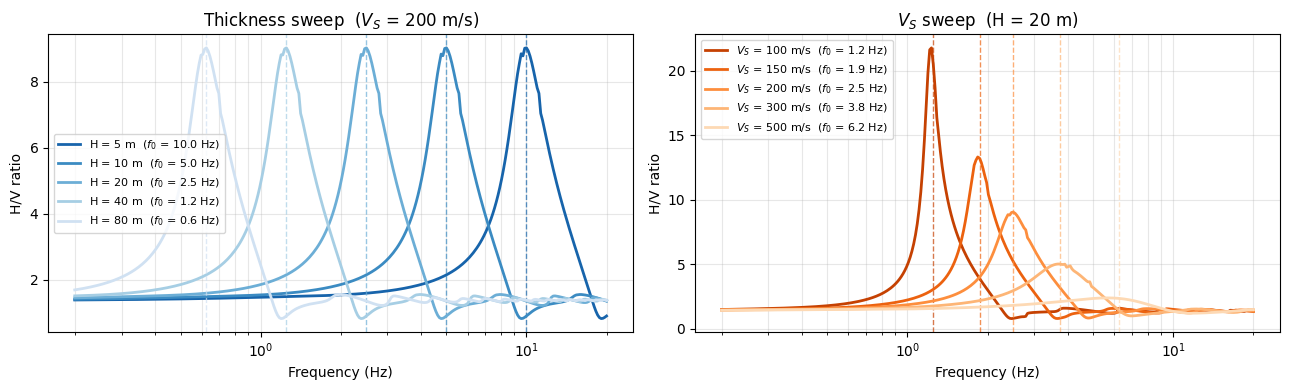

In [4]:
cmap_h  = cm.Blues_r
cmap_vs = cm.Oranges_r

fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=False)

# ── Thickness sweep ─────────────────────────────────────────────────────────
ax = axes[0]
for i, (H, r) in enumerate(zip(thicknesses, h_results)):
    color = cmap_h(0.2 + 0.6 * i / (len(thicknesses) - 1))
    f0_theory = VS_FIXED / (4 * H)
    ax.semilogx(r.freq, r.hv, color=color, linewidth=2,
                label=f"H = {H} m  ($f_0$ = {f0_theory:.1f} Hz)")
    ax.axvline(f0_theory, color=color, linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("H/V ratio")
ax.set_title(f"Thickness sweep  ($V_S$ = {VS_FIXED:.0f} m/s)")
ax.legend(fontsize=8)
ax.grid(True, which="both", alpha=0.3)

# ── Vs sweep ─────────────────────────────────────────────────────────────────
ax2 = axes[1]
for i, (VS, r) in enumerate(zip(vs_values, vs_results)):
    color = cmap_vs(0.2 + 0.6 * i / (len(vs_values) - 1))
    f0_theory = VS / (4 * H_FIXED)
    ax2.semilogx(r.freq, r.hv, color=color, linewidth=2,
                 label=f"$V_S$ = {VS} m/s  ($f_0$ = {f0_theory:.1f} Hz)")
    ax2.axvline(f0_theory, color=color, linestyle='--', linewidth=1, alpha=0.7)
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("H/V ratio")
ax2.set_title(f"$V_S$ sweep  (H = {H_FIXED:.0f} m)")
ax2.legend(fontsize=8)
ax2.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.show()

## DFA peak vs. quarter-wavelength theory

The DFA picks up the true resonance, which can exceed the quarter-wavelength
estimate for high impedance contrasts. The table below compares both.

In [5]:
print(f"{'H (m)':>6}  {'Vs (m/s)':>8}  {'f0 theory (Hz)':>14}  {'f0 DFA (Hz)':>11}  {'ratio':>6}")
print("-" * 55)
for H, r in zip(thicknesses, h_results):
    f0_t = VS_FIXED / (4 * H)
    f0_d = r.freq[r.hv.argmax()]
    print(f"{H:>6}  {VS_FIXED:>8.0f}  {f0_t:>14.2f}  {f0_d:>11.2f}  {f0_d/f0_t:>6.3f}")

print()
for VS, r in zip(vs_values, vs_results):
    f0_t = VS / (4 * H_FIXED)
    f0_d = r.freq[r.hv.argmax()]
    print(f"{H_FIXED:>6.0f}  {VS:>8}  {f0_t:>14.2f}  {f0_d:>11.2f}  {f0_d/f0_t:>6.3f}")

 H (m)  Vs (m/s)  f0 theory (Hz)  f0 DFA (Hz)   ratio
-------------------------------------------------------
     5       200           10.00        10.00   1.000
    10       200            5.00         5.00   1.000
    20       200            2.50         2.50   1.000
    40       200            1.25         1.25   1.000
    80       200            0.62         0.63   1.000

    20       100            1.25         1.23   0.985
    20       150            1.88         1.84   0.980
    20       200            2.50         2.50   1.000
    20       300            3.75         3.73   0.995
    20       500            6.25         5.66   0.905
